### First things first

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion 
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler

from sklearn.naive_bayes import MultinomialNB


In [2]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
df = pd.read_csv('train.csv').drop(columns = 'id')
df.head()

,text,is_humor,humor_rating,humor_controversy,offense_rating
0,TENNESSEE: We're the best state. Nobody even c...,1,2.42,1.0,0.2
1,A man inserted an advertisement in the classif...,1,2.50,1.0,1.1
2,How many men does it take to open a can of bee...,1,1.95,0.0,2.4
3,Told my mom I hit 1200 Twitter followers. She ...,1,2.11,1.0,0.0
4,Roses are dead. Love is fake. Weddings are bas...,1,2.78,0.0,0.1


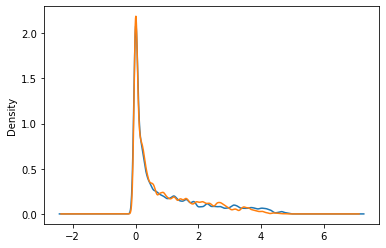

In [37]:
dfr = df[df['is_humor']==1]
for k,v in dfr.groupby('humor_controversy'):
    v.offense_rating.plot.kde(0.05)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df[['text']], df['is_humor'], test_size = 0.2, random_state = 21)

In [5]:
X_train.describe()

,text
count,6400
unique,6400
top,"Don't bite your nails mate, it's a nasty habit..."
freq,1


In [6]:
total = len(y_train)
print('% of positives is ', round(y_train.sum()/total, 2)) #'% of positives is {:.2f}'.format(y_train.sum()/total)
print('% of negatives is ', round((total - y_train.sum())/total, 2)) #'% of negatives is {:.2f}'.format((total - y_train.sum())/total)

% of positives is  0.61
% of negatives is  0.39


(array([2466.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3934.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

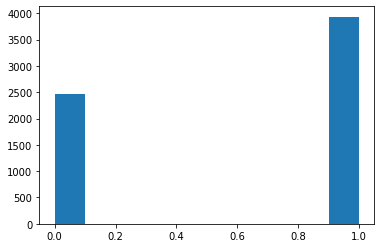

In [7]:
plt.hist(y_train)

In [8]:
def stemmer(text, stemmer):
    return(' '.join([stemmer.stem(w) for w in word_tokenize(text)]))

def count_words(input):
    """ Returns number of occurences of characters specified in char """     
    return len(input.split())

def remove_punctuation(s_input, include_char = None):
    """ Returns input string without punctuation """
    import string as String
    punct = String.punctuation
    
    if not include_char is None:
        index = String.punctuation.index(include_char)
        punct = String.punctuation[:index] + String.punctuation[(index + 1):]
        
    punct += '\n'
        
    translator = str.maketrans(punct, ' '*len(punct))
    
    return s_input.translate(translator)

def remove_stopwords(text, use_stopwords = None, df = True, exclude_number = True):
    """ Returns input string removing stopwords from it. """
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    
    if use_stopwords is None:
        use_stopwords = set(stopwords.words("english"))
        
    if df:
        new_text = word_tokenize(text)
        if exclude_number:
            new_text = [word for word in new_text if not word.isnumeric()]
        new_text = " ".join([word for word in new_text if word not in use_stopwords])
    else:
        new_text = ""
        for word in text:
            if word not in use_stopwords:
                new_text += word + " "

    return new_text

def sep_upper(text):
    """ Take a text as input and insert space before every uppercase letter. """
    
    new_text = ""
    for letter in text:
        if letter.isupper():
            new_text += " " + letter
        else:
            new_text += letter
    
    return new_text

def remove_space(text):
    return(re.sub(' +',' ',text)) 

In [9]:
def pre_proc(text_col):
    text_col = text_col.apply(remove_punctuation) # removes String.punctuation characters
    #text_col = text_col.apply(remove_stopwords)   # removes english stopwords 
    text_col = text_col.str.replace('[^\w\s]','').str.strip() # and removes whitespaces
    text_col = text_col.apply(sep_upper) # adds space before an uppercase
    text_col = text_col.str.lower() # lowercase
    
    return text_col

In [10]:
X_train.text = pre_proc(X_train.text)
X_test.text = pre_proc(X_test.text)

In [11]:
X_train['qtd_words'] = X_train.text.apply(count_words)
X_test['qtd_words'] = X_test.text.apply(count_words)

In [12]:
X_test.head()

,text,qtd_words
1705,like if i had information i could dismiss fro...,15
6185,since my wife left i ve bought a harley d...,36
899,there s a man walking a tight rope 100ft bel...,33
7453,my wife yelled at me saying you weren t ev...,26
2772,bipolar depression is technically referred to...,21


# additions by iago

In [13]:
import numpy as np

from sklearn.utils.class_weight import compute_class_weight

from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

 1. add weight balancing
 2. check other classification models: logistic regression, svc, gaussian NB
 3. apply grid search to for mnb and logit
 4. register and compare the accuracy and other metrics per model
 

In [14]:
class_labels = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels,y= y_train)
class_weights = dict(zip(class_labels, class_weights))

In [15]:
##%% this code didnt improve the baseline model
parameters = {'alpha':[ 0.01, 100]}

svc = SVC(max_iter=10000,tol=0.00001,random_state=42,class_weight=class_weights,probability=True) #,class_weight=class_weights
lr = LogisticRegression(max_iter=10000,tol=0.00001,class_weight=class_weights,random_state=42) #class_weight=class_weights,

gnb = GaussianNB()
mnb = MultinomialNB()
gridSearch = GridSearchCV(mnb, param_grid=parameters, scoring='accuracy')

models ={'svc':svc,
         'lr':lr,
         #'gnb': gnb,
         'grid_mnb':gridSearch,
         'mnb':mnb}

In [17]:
get_text_data = FunctionTransformer(lambda x: x['text'], validate=False)
get_numerical_data = FunctionTransformer(lambda x: x[['qtd_words']], validate=False)

dictResults = {}
for el in models.keys():
    print(el)
    process_and_join_features = Pipeline([('features', FeatureUnion([
        ('text_features', Pipeline([('selector', get_text_data), 
                                ('vec', CountVectorizer())])),
        ('nume_features', Pipeline([('selector', get_numerical_data), 
                                ('scaler', MinMaxScaler())]))
        ])),
        ('clf', models[el])
                                      ])
    process_and_join_features.fit(X_train, y_train)
    y_pred = process_and_join_features.predict(X_test)
    tn,fp,fn,tp = confusion_matrix(y_test,y_pred).ravel()
    acc = (tn + tp)/y_test.size
    recall = tp/(tp + fn)
    fpr = fp/(fp + tn)
    prec = tp/(tp + fp)
    f1Score = 2*(recall*prec)/(recall + prec)
    print("\t-> acc: ",acc)
    print("\t-> recall: ",recall)
    print("\t-> prec: ",prec)
    print("\t-> f1-score: ",f1Score)
    dictResults[el] = [acc,recall,fpr,prec,tn,fp,fn,tp,f1Score]

svc
	-> acc:  0.833125
	-> recall:  0.8276553106212425
	-> prec:  0.8968512486427795
	-> f1-score:  0.8608650338718082
lr
	-> acc:  0.84625
	-> recall:  0.8517034068136272
	-> prec:  0.8966244725738397
	-> f1-score:  0.8735868448098664
grid_mnb
	-> acc:  0.84125
	-> recall:  0.872745490981964
	-> prec:  0.872745490981964
	-> f1-score:  0.8727454909819639
mnb
	-> acc:  0.85125
	-> recall:  0.9138276553106213
	-> prec:  0.8571428571428571
	-> f1-score:  0.8845780795344325


In [18]:
dfResults = pd.DataFrame(dictResults).transpose()
dfResults.columns = ['acc','recall','fpr','prec','tn','fp','fn','tp','f1-score']

bestModel = dfResults['acc'].idxmax()
print("model with best accuracy: ",bestModel)
dfResults.head()

model with best accuracy:  mnb


,acc,recall,fpr,prec,tn,fp,fn,tp,f1-score
svc,0.833125,0.827655,0.157807,0.896851,507.0,95.0,172.0,826.0,0.860865
lr,0.846250,0.851703,0.162791,0.896624,504.0,98.0,148.0,850.0,0.873587
grid_mnb,0.841250,0.872745,0.210963,0.872745,475.0,127.0,127.0,871.0,0.872745
mnb,0.851250,0.913828,0.252492,0.857143,450.0,152.0,86.0,912.0,0.884578


## report

1. Multinomial NB seems to be better than the other models, although Gaussian NB couldnt be tested
2. Grid search does not improve the results, in fact me

In [20]:
process_and_join_features.fit(X_train, y_train)
predicted_CountVectorizer = process_and_join_features.predict(X_test)

In [21]:
from sklearn import metrics

print(metrics.accuracy_score(y_test, predicted_CountVectorizer))

0.85125


In [22]:
df.iloc[1705].text

'Like if i had information i could dismiss from my brain it would be this'

In [23]:
X_test.loc[1705].text

' like if i had information i could dismiss from my brain it would be this'